In [2]:
import numpy as np
from qcodes.utils.validators import Numbers, Arrays
from qcodes.instrument.base import Instrument
from qcodes.dataset.measurements import Measurement

from qcodes.instrument.parameter import ParameterWithSetpoints, Parameter
from qcodes.utils import validators
from qcodes.utils.dataset.doNd import do0d, do1d
from qcodes.dataset.plotting import plot_by_id

In [3]:
class GeneratedSetPoints(Parameter):
    """
    A parameter that generates a setpoint array from start, stop and num points
    parameters.
    """
    def __init__(self, name, startparam, stopparam, numpointsparam, *args, **kwargs):
        super().__init__(name, *args, **kwargs)
        self._startparam = startparam
        self._stopparam = stopparam
        self._numpointsparam = numpointsparam

    def get_raw(self):
        return np.linspace(self._startparam(), self._stopparam(),
                              self._numpointsparam())

class DummyArray(ParameterWithSetpoints):

    def get_raw(self):
        npoints = self.root_instrument.n_points.get_latest()
        return np.random.rand(npoints)
    
class DummyArrayXY(ParameterWithSetpoints):

    def get_raw(self):
        npoints = self.root_instrument.n_points.get_latest()
        return np.random.random((npoints,npoints))


class DummySpectrumAnalyzer(Instrument):

    def __init__(self, name, **kwargs):

        super().__init__(name, **kwargs)


        self.add_parameter('f_start',
                           initial_value=0,
                           unit='Hz',
                           label='f start',
                           vals=Numbers(0,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('f_stop',
                           initial_value=10,
                           unit='Hz',
                           label='f stop',
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('n_points',
                           unit='',
                           initial_value=10,
                           vals=Numbers(1,1e3),
                           get_cmd=None,
                           set_cmd=None)

        self.add_parameter('freq_axis',
                           unit='Hz',
                           label='Freq Axis',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.f_start,
                           stopparam=self.f_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points.get_latest,)))
        
        self.add_parameter('freq_axisy',
                           unit='Hz',
                           label='Freq Axis',
                           parameter_class=GeneratedSetPoints,
                           startparam=self.f_start,
                           stopparam=self.f_stop,
                           numpointsparam=self.n_points,
                           vals=Arrays(shape=(self.n_points.get_latest,)))

        self.add_parameter('spectrum',
                   unit='dBm',
                   setpoints=(self.freq_axis,),
                   label='Spectrum',
                   parameter_class=DummyArray,
                   vals=Arrays(shape=(self.n_points.get_latest,)))
        
        self.add_parameter('spectrumxy',
                   unit='dBm',
                   setpoints=(self.freq_axis, self.freq_axisy),
                   label='Spectrumxy',
                   parameter_class=DummyArrayXY,
                   vals=Arrays(shape=(self.n_points.get_latest, self.n_points.get_latest)))

In [4]:
class MyCounter(Parameter):
    def __init__(self, name):
        # only name is required
        super().__init__(name, label='Times this has been read',
                         vals=validators.Numbers(min_value=0),
                         docstring='counts how many times get has been called '
                                   'but can be reset to any integer >= 0 by set')
        self._count = 0

    # you must provide a get method, a set method, or both.
    def get_raw(self):
        self._count += 1
        return int(self._count)

    def set_raw(self, val):
        self._count = int(val)
        return self._count

In [5]:
spec = DummySpectrumAnalyzer('test')
mycounter = MyCounter('counter')

In [5]:
meas = Measurement()
# Register the independent parameter...
meas.register_parameter(spec.spectrum)

with meas.run() as datasaver:
    datasaver.add_result((spec.spectrum, spec.spectrum()))

Starting experimental run with id: 105. 


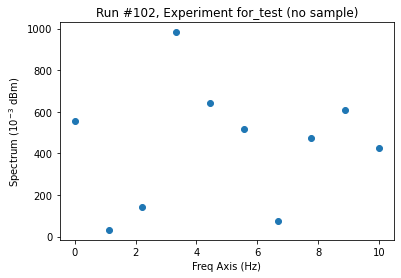

In [6]:
plot = plot_by_id(102)

In [7]:
meas2 = Measurement()
# Register the independent parameter...
meas2.register_parameter(spec.freq_axis)
meas2.register_parameter(spec.spectrum, setpoints=(spec.freq_axis,))

with meas2.run() as datasaver:
    datasaver.add_result((spec.spectrum, spec.spectrum()),
                         (spec.freq_axis, spec.freq_axis()))

Starting experimental run with id: 106. 


In [8]:
meas3 = Measurement()
# Register the independent parameter...
mycounter(0)
meas3.register_parameter(mycounter)
meas3.register_parameter(spec.freq_axis)
meas3.register_parameter(spec.spectrum, setpoints=(spec.freq_axis,mycounter))
with meas3.run() as datasaver:
    for i in range(10):
        mycounter(i)
        datasaver.add_result((spec.spectrum, spec.spectrum()),
                             (spec.freq_axis, spec.freq_axis()),
                             (mycounter,mycounter()))

Starting experimental run with id: 107. 


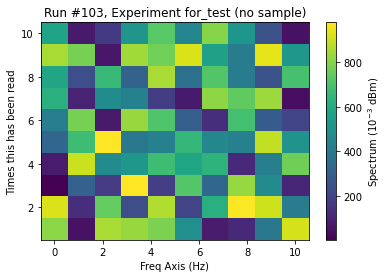

In [9]:
plot = plot_by_id(103)

Starting experimental run with id: 109. Using 'qcodes.utils.dataset.doNd.do1d'


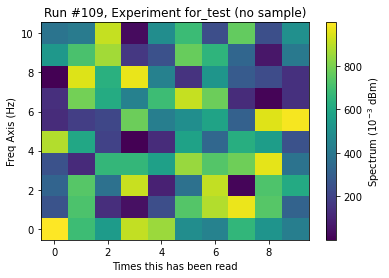

In [11]:
result_1d = do1d(mycounter, 0, 9, 10, 0.01, spec.spectrum, do_plot=True)

In [12]:
meas = Measurement()
# Register the independent parameter...
meas.register_parameter(spec.spectrumxy)

with meas.run() as datasaver:
    datasaver.add_result((spec.spectrumxy, spec.spectrumxy()))
databla = datasaver.dataset


Starting experimental run with id: 110. 


In [14]:
do0d(spec.spectrumxy)

Starting experimental run with id: 112. Using 'qcodes.utils.dataset.doNd.do0d'


(results #112@C:\Users\rbcma\experiments.db
 ------------------------------------------
 test_freq_axis - array
 test_freq_axisy - array
 test_spectrumxy - array,
 [None],
 [None])

In [15]:
meas = Measurement()
# Register the independent parameter...
meas.register_parameter(spec.spectrumxy)

with meas.run() as datasaver:
    datasaver.add_result((spec.spectrumxy, spec.spectrumxy()))
databla = datasaver.dataset

Starting experimental run with id: 113. 


([<AxesSubplot:title={'center':'Run #113, Experiment for_test (no sample)'}, xlabel='Freq Axis (Hz)', ylabel='Freq Axis (Hz)'>],
 [<matplotlib.colorbar.Colorbar at 0x1fd76b16b20>])

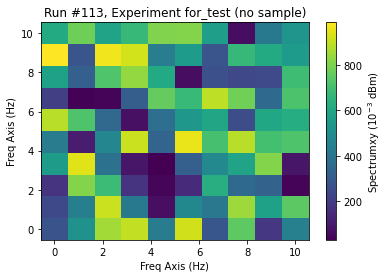

In [16]:
plot_by_id(113)

# Options to (possibly) make it faster

In [12]:
meas = Measurement()
# Register the independent parameter...
meas.register_parameter(mycounter)
meas.register_parameter(spec.spectrumxy,setpoints=(mycounter,),paramtype='array')
meas.write_period = 5
with meas.run(write_in_background=True, in_memory_cache=False) as datasaver:
    for i in range(3):
        mycounter(i)
        datasaver.add_result((spec.spectrumxy, spec.spectrumxy()),
                             (mycounter, mycounter()))
databla = datasaver.dataset

Starting experimental run with id: 122. 


Multi-dimensional data encountered. parameter test_spectrumxy depends on 3 parameters, cannot plot that.


([<AxesSubplot:>], [None])

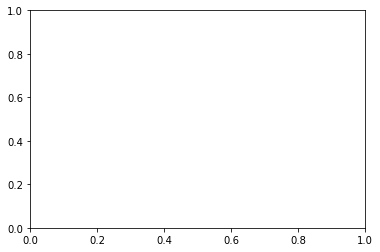

In [13]:
plot_by_id(122)


In [14]:
df = databla.to_pandas_dataframe()

In [15]:
df2 = df[df.index.isin([2], level=0)].reset_index()
df2.head()

,counter,test_freq_axis,test_freq_axisy,test_spectrumxy
0,2.0,0.0,0.000000,0.773082
1,2.0,0.0,1.111111,0.656250
2,2.0,0.0,2.222222,0.939439
3,2.0,0.0,3.333333,0.151200
4,2.0,0.0,4.444444,0.959678


<AxesSubplot:xlabel='test_freq_axis', ylabel='test_freq_axisy'>

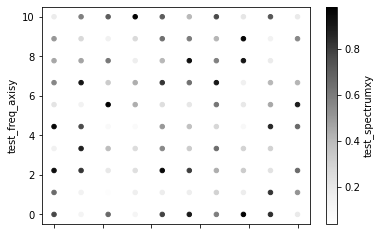

In [16]:
df2.plot.scatter('test_freq_axis', 'test_freq_axisy', c='test_spectrumxy')

In [36]:
result_1d = do1d(mycounter, 0, 9, 10, 0.01, spec.spectrumxy, do_plot=False)

Starting experimental run with id: 118. Using 'qcodes.utils.dataset.doNd.do1d'


<AxesSubplot:xlabel='test_freq_axis', ylabel='test_freq_axisy'>

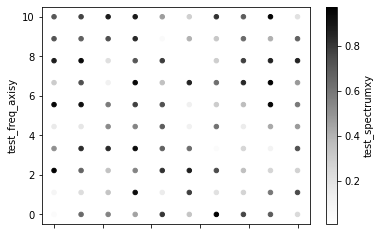

In [39]:
df = result_1d[0].to_pandas_dataframe()
df2 = df[df.index.isin([2], level=0)].reset_index()
df2.plot.scatter('test_freq_axis', 'test_freq_axisy', c='test_spectrumxy')

<AxesSubplot:xlabel='test_freq_axis', ylabel='test_freq_axisy'>

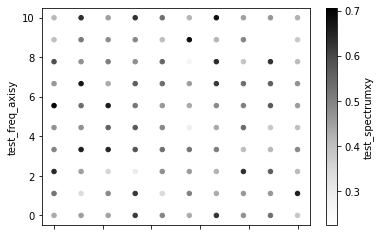

In [40]:
df3 = df.groupby(['test_freq_axis', 'test_freq_axisy']).mean()
df3.reset_index().plot.scatter('test_freq_axis', 'test_freq_axisy', c='test_spectrumxy')

In [ ]:
res = []
setpoint_params = []
setpoint_data = []
results = None
parameter = spec.spectrumxy
for setpointparam in parameter.setpoints:
    these_setpoints = setpointparam.get()
    setpoint_params.append(setpointparam)
    setpoint_data.append(these_setpoints)
output_grids = np.meshgrid(*setpoint_data, indexing='ij')
for param, grid in zip(setpoint_params, output_grids):
    res.append((param, grid))
if results is None:
    data = parameter.get()
else:
    data = results
res.append((parameter, data))

Below is there some example that Intuitively should work, but do not :-(

In [ ]:
meas2 = Measurement()
# Register the independent parameter...
meas2.register_parameter(spec.freq_axis)
meas2.register_parameter(spec.freq_axisy)
meas2.register_parameter(spec.spectrumxy, setpoints=(spec.freq_axis, spec.freq_axisy))

with meas2.run() as datasaver:
    datasaver.add_result((spec.spectrumxy, spec.spectrumxy()),
                         (spec.freq_axis, spec.freq_axis()),
                         (spec.freq_axisy, spec.freq_axisy()))

In [ ]:
meas4 = Measurement()
# Register the independent parameter...
mycounter(0)
meas4.register_parameter(mycounter)
meas4.register_parameter(spec.freq_axis)
meas4.register_parameter(spec.freq_axisy)
meas4.register_parameter(spec.spectrumxy, setpoints=(spec.freq_axis, spec.freq_axisy, mycounter))
with meas4.run() as datasaver:
    for i in range(10):
        mycounter(i)
        #output_grids = np.meshgrid(spec.freq_axis.get(),spec.freq_axisy.get(), indexing='ij')
        datasaver.add_result((spec.spectrumxy, spec.spectrumxy()),
                             (spec.freq_axis, spec.freq_axis.get()),
                             (spec.freq_axisy, spec.freq_axisy.get()),
                             (mycounter, mycounter()))
databla = datasaver.dataset